In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install language_tool_python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.7/54.7 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 3.3 MB/s eta 0:00:00


## Imports

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import librosa
import pandas as pd
import numpy as np
from tqdm import tqdm 
from transformers import pipeline
import language_tool_python
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

2025-05-03 03:58:48.010341: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746244728.309917      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746244728.394854      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Update JAVA version

In [4]:
!apt-get install -y openjdk-17-jdk
!update-alternatives --set java /usr/lib/jvm/java-17-openjdk-amd64/bin/java

!java -version

!pip install --upgrade language-tool-python

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fonts-dejavu-core fonts-dejavu-extra libatk-wrapper-java libatk-wrapper-java-jni libxtst6
  libxxf86dga1 openjdk-17-jdk-headless openjdk-17-jre openjdk-17-jre-headless x11-utils
Suggested packages:
  openjdk-17-demo openjdk-17-source visualvm libnss-mdns fonts-ipafont-gothic fonts-ipafont-mincho
  fonts-wqy-microhei | fonts-wqy-zenhei fonts-indic mesa-utils
The following NEW packages will be installed:
  fonts-dejavu-core fonts-dejavu-extra libatk-wrapper-java libatk-wrapper-java-jni libxtst6
  libxxf86dga1 openjdk-17-jdk openjdk-17-jdk-headless openjdk-17-jre openjdk-17-jre-headless
  x11-utils
0 upgraded, 11 newly installed, 0 to remove and 122 not upgraded.
Need to get 125 MB of archives.
After this operation, 286 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 fonts-dejavu-core all 2

## Device assignment

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data Loading
train_df = pd.read_csv('/kaggle/input/shl-intern-hiring-assessment/Dataset/train.csv')
test_df = pd.read_csv('/kaggle/input/shl-intern-hiring-assessment/Dataset/test.csv')

## Extract Audio Features Function

In [6]:
# Feature Extraction Functions
def extract_audio_features(file_path):
    y, sr = librosa.load(file_path, sr=16000)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    return np.concatenate([np.mean(mfcc, axis=1), 
                          np.mean(chroma, axis=1), 
                          np.mean(contrast, axis=1)])

asr_pipe = pipeline("automatic-speech-recognition", 
                   model="openai/whisper-medium",
                   device=0 if torch.cuda.is_available() else -1,
                   return_timestamps=True)

tool = language_tool_python.LanguageTool('en-US')

def process_text_features(text):
    matches = tool.check(text)
    error_count = len(matches)
    error_types = len({m.ruleId for m in matches})
    word_count = len(text.split())
    return np.array([error_count, error_types, word_count])


config.json:   0%|          | 0.00/1.99k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.06G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/3.75k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/283k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/836k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.19k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/185k [00:00<?, ?B/s]

Device set to use cuda:0


## Preprocess Data Function

In [7]:
# Data Preprocessing
def preprocess_data(df, is_train=True, num_samples=None):
    features = []
    labels = [] if is_train else None
    
    for idx, row in tqdm(df.iterrows()):
        if is_train:
            file_path = '/kaggle/input/shl-intern-hiring-assessment/Dataset/audios/train/' + row["filename"]
        else:
            file_path = '/kaggle/input/shl-intern-hiring-assessment/Dataset/audios/test/' + row["filename"]  
        
        audio_feat = extract_audio_features(file_path)
        text = asr_pipe(file_path)["text"]
        text_feat = process_text_features(text)
        combined_feat = np.concatenate([audio_feat, text_feat])
        features.append(combined_feat)
        
        if is_train:
            labels.append(row['label'])
    
    return (np.array(features), np.array(labels)) if is_train else np.array(features)



## Spliting Training and Validation

In [8]:
X_train, y_train = preprocess_data(train_df, num_samples=300)

# Split for validation
X_train_full, X_val, y_train_full, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

# Feature scaling
audio_scaler = StandardScaler().fit(X_train_full[:, :59])
text_scaler = StandardScaler().fit(X_train_full[:, 59:])

def scale_features(features):
    audio = audio_scaler.transform(features[:, :59])
    text = text_scaler.transform(features[:, 59:])
    return np.concatenate([audio, text], axis=1)

X_train_scaled = scale_features(X_train_full)
X_val_scaled = scale_features(X_val)

0it [00:00, ?it/s]Due to a bug fix in https://github.com/huggingface/transformers/pull/28687 transcription using a multilingual Whisper will default to language detection followed by transcription instead of translation to English.This might be a breaking change for your use case. If you want to instead always translate your audio to English, make sure to pass `language='en'`.
Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.
1it [00:48, 48.20s/it]Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.
2it [00:51, 21.57s/it]Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.
3it [01:19, 24.47s/it]Whisper 

In [9]:
# np.save('/kaggle/output/train__x', X_train)
# np.save("'/kaggle/output/train__x', X_train")
# np.save('/kaggle/output/train__y', y_train)

## Dataset and DataLoader

In [10]:
# Dataset and DataLoader
class GrammarDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return (torch.tensor(self.features[idx], dtype=torch.float32),
                torch.tensor(self.labels[idx], dtype=torch.float32))

train_dataset = GrammarDataset(X_train_scaled, y_train_full)
val_dataset = GrammarDataset(X_val_scaled, y_val)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

## Model

In [11]:
 # Model Architecture
class GrammarModel(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        return self.net(x).squeeze()

model = GrammarModel(X_train_scaled.shape[1]).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.2, patience=5)


## Training

In [12]:
# Training with Early Stopping
best_loss = float('inf')
patience = 10
no_improve = 0
train_losses = []
val_losses = []

for epoch in range(100):
    # Training
    model.train()
    epoch_loss = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item() * inputs.size(0)
    train_loss = epoch_loss / len(train_loader.dataset)
    train_losses.append(train_loss)
    
    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            val_loss += criterion(outputs, targets).item() * inputs.size(0)
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    
    # Update scheduler
    scheduler.step(val_loss)
    
    # Early stopping
    if val_loss < best_loss:
        best_loss = val_loss
        no_improve = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        no_improve += 1
        
    print(f'Epoch {epoch+1:03d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}')
    
    if no_improve >= patience:
        print(f'Early stopping at epoch {epoch+1}')
        break


Epoch 001 | Train Loss: 14.8691 | Val Loss: 10.3483
Epoch 002 | Train Loss: 8.0208 | Val Loss: 3.6422
Epoch 003 | Train Loss: 2.1489 | Val Loss: 2.0874
Epoch 004 | Train Loss: 1.9736 | Val Loss: 1.8114
Epoch 005 | Train Loss: 1.4353 | Val Loss: 1.7082
Epoch 006 | Train Loss: 1.4448 | Val Loss: 1.5164
Epoch 007 | Train Loss: 1.2001 | Val Loss: 1.5667
Epoch 008 | Train Loss: 1.1117 | Val Loss: 1.4987
Epoch 009 | Train Loss: 1.0368 | Val Loss: 1.4155
Epoch 010 | Train Loss: 1.0377 | Val Loss: 1.4434
Epoch 011 | Train Loss: 0.8787 | Val Loss: 1.4033
Epoch 012 | Train Loss: 0.9030 | Val Loss: 1.3779
Epoch 013 | Train Loss: 0.8889 | Val Loss: 1.4622
Epoch 014 | Train Loss: 0.8382 | Val Loss: 1.3914
Epoch 015 | Train Loss: 0.9019 | Val Loss: 1.3326
Epoch 016 | Train Loss: 0.8025 | Val Loss: 1.3118
Epoch 017 | Train Loss: 0.7890 | Val Loss: 1.2960
Epoch 018 | Train Loss: 0.7432 | Val Loss: 1.3232
Epoch 019 | Train Loss: 0.7672 | Val Loss: 1.3203
Epoch 020 | Train Loss: 0.7149 | Val Loss: 1.262

## Evaluation Metrics along with graphs loss curves and prediction distribution

Training Metrics:
RMSE: 0.8248
MAE: 0.6411
R²: 0.3801
Pearson: 0.6303


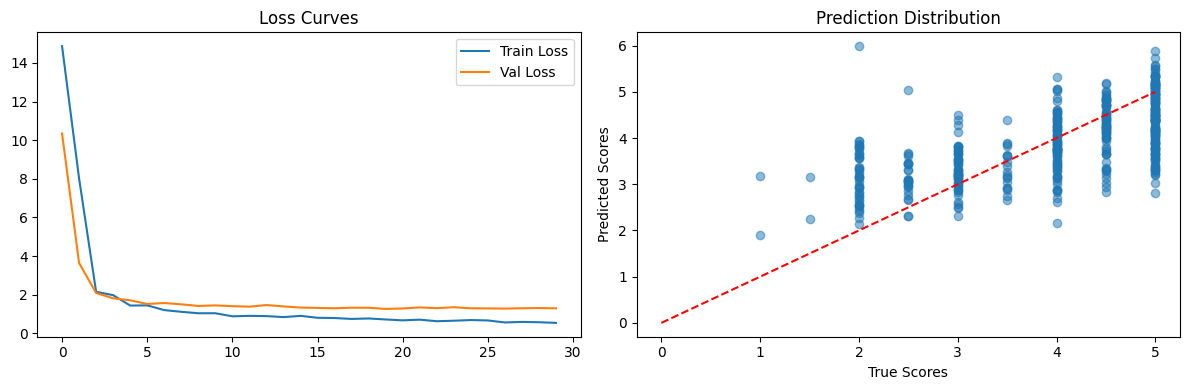

In [13]:
# Training Evaluation
model.load_state_dict(torch.load('best_model.pth'))
model.eval()
with torch.no_grad():
    y_pred = model(torch.tensor(scale_features(X_train), dtype=torch.float32).to(device)).cpu().numpy()

rmse = np.sqrt(mean_squared_error(y_train, y_pred))
mae = mean_absolute_error(y_train, y_pred)
r2 = r2_score(y_train, y_pred)
pearson, _ = pearsonr(y_train, y_pred)

print(f'Training Metrics:')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'R²: {r2:.4f}')
print(f'Pearson: {pearson:.4f}')

# 10. Visualization
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title('Loss Curves')

plt.subplot(1, 2, 2)
plt.scatter(y_train, y_pred, alpha=0.5)
plt.plot([0,5], [0,5], 'r--')
plt.xlabel('True Scores')
plt.ylabel('Predicted Scores')
plt.title('Prediction Distribution')
plt.tight_layout()
plt.show()


## Test Prediction

In [14]:
# Test Prediction
# Preprocess test data
X_test = preprocess_data(test_df, is_train=False, num_samples = 50)
X_test_scaled = scale_features(X_test)

# Predict
model.eval()
with torch.no_grad():
    test_pred = model(torch.tensor(X_test_scaled, dtype=torch.float32).to(device)).cpu().numpy()

# Generate submission
submission_df = pd.read_csv('/kaggle/input/shl-intern-hiring-assessment/Dataset/sample_submission.csv')
submission_df['label'] = np.clip(test_pred, 0, 5)  # This is to ensure that the scores are in [0,5]

0it [00:00, ?it/s]Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.
3it [00:13,  4.68s/it]Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.
4it [00:19,  4.94s/it]Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.
8it [00:38,  4.87s/it]Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.
13it [01:03,  5.05s/it]Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used du